# Detección de anomalias analizando jugadores de la NBA
_El objetivo de este proyecto es la agrupación de jugadores de la NBA atendiendo a su edad y a la mejora de rendimiento en alguna de las principales estadísticas de rendimiento, comparando datos de Playoffs vs Regular Season. Un valor muy buscado por los equipos contenders en la actualidad y que su identificación y capacidad de anticipación en el mercado es uno de los puntos fuertes en toda planificación deportiva en la liga_ 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [ ]:
df_RS = pd.read_csv('2022-2023 NBA Player Stats - Regular.csv', delimiter=";", encoding="latin-1")
df_PO = pd.read_csv('2022-2023 NBA Player Stats - Playoffs.csv', delimiter=";", encoding="latin-1")

In [3]:
df_RS_ = pd.merge(df_PO, df_RS , on=['Player', 'Tm'], how='inner').filter(regex='^(?!.*_x$)')
df_PO_ = pd.merge(df_PO, df_RS_ , on=['Player', 'Tm'], how='inner').filter(regex='^(?!.*_y$)')

In [4]:
RS_columns = {col: col.split('_')[0] for col in df_RS_.columns}
PO_columns = {col: col.split('_')[0] for col in df_PO_.columns}
df_RS_.rename(columns=RS_columns, inplace=True)
df_PO_.rename(columns=PO_columns, inplace=True)

In [5]:
print(df_PO_['Age'].values.max()*0.5 + df_PO_['Age'].values.min()*0.5)

30.5


In [6]:
set(df_PO_.columns) == set(df_RS_.columns)

True

In [7]:
cols = df_PO_.columns.values

df_dif = df_PO_.copy()
df_dif[cols[7:]] = df_dif[cols[7:]] - df_RS_[cols[7:]]

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_dif[list(cols[7:])+['Age']] = scaler.fit_transform(df_dif[list(cols[7:])+['Age']])

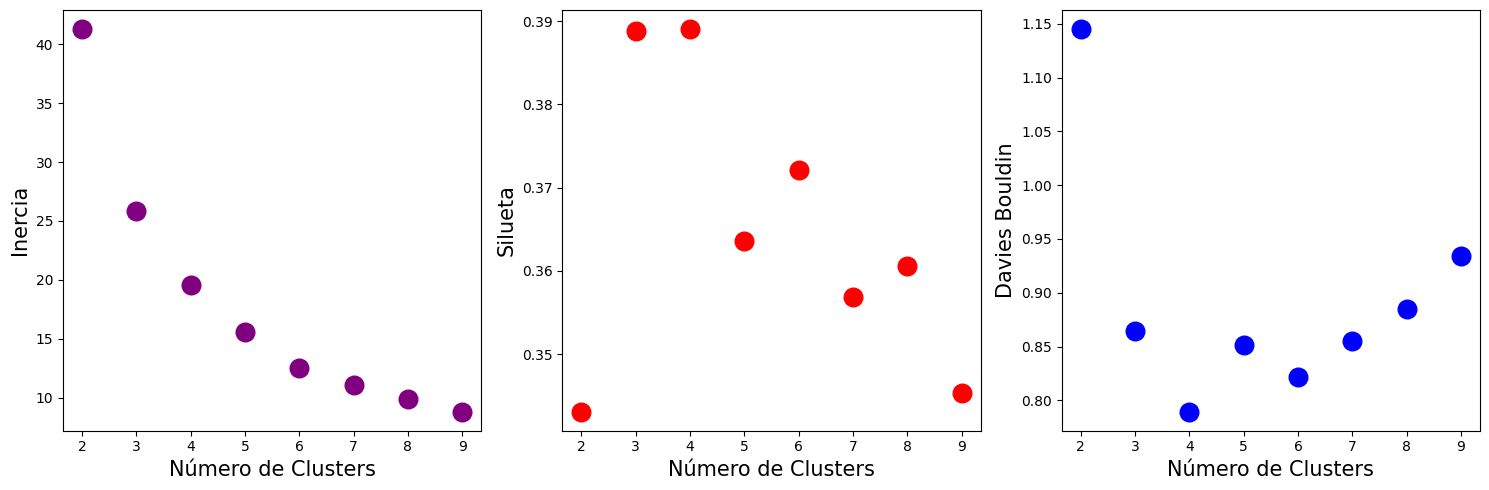

In [77]:
a = 'MP'
b = 'Age'

X = df_dif[[a, b]].values

inercias = []
siluetas = []
davies_bouldins = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    silueta = silhouette_score(X, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(X, kmeans.labels_)
    inercias.append(kmeans.inertia_)
    siluetas.append(silueta)
    davies_bouldins.append(davies_bouldin)

    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Subplot para Inercia
axs[0].scatter(range(2, 10), inercias, marker="o", s=180, color="purple")
axs[0].set_xlabel("Número de Clusters", fontsize=15)
axs[0].set_ylabel("Inercia", fontsize=15)

# Subplot para Silueta
axs[1].scatter(range(2, 10), siluetas, marker="o", s=180, color="red")
axs[1].set_xlabel("Número de Clusters", fontsize=15)
axs[1].set_ylabel("Silueta", fontsize=15)

# Subplot para Davies Bouldin
axs[2].scatter(range(2, 10), davies_bouldins, marker="o", s=180, color="blue")
axs[2].set_xlabel("Número de Clusters", fontsize=15)
axs[2].set_ylabel("Davies Bouldin", fontsize=15)

# Ajustar espaciado entre subplots y mostrar gráficos
plt.tight_layout()
plt.show()

In [78]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(X)

In [82]:
x_mean = df_RS['Age'].mean()
min_value = df_RS['Age'].min()
max_value = df_RS['Age'].max()
max_range = 1.0
min_range = -1.0

x_mean_norm = (x_mean - min_value) / (max_value - min_value) * (max_range - min_range) + min_range
print(x_mean_norm)

-0.3891272331433694


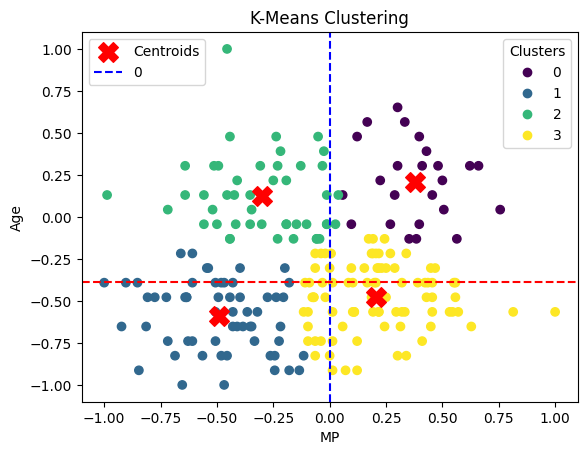

In [83]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label="Centroids")

plt.axvline(x=0, color='blue', linestyle='--', label="0")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

In [91]:
distances = pairwise_distances(X, centroids, metric='euclidean')
distances_to_centroids = np.min(distances, axis=1)

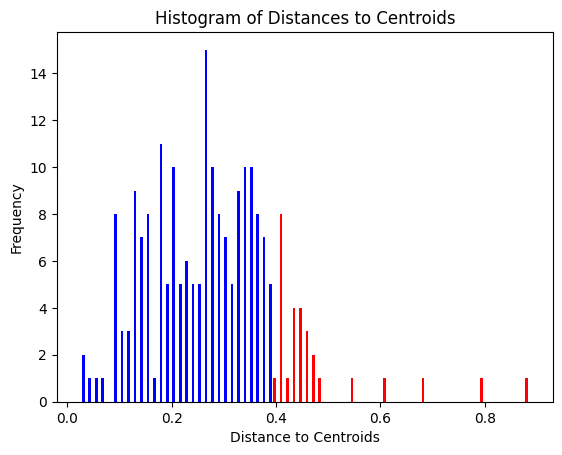

In [179]:
threshold = 0.4
distances_above_threshold = distances_to_centroids[distances_to_centroids > threshold]
distances_below_threshold = distances_to_centroids[distances_to_centroids <= threshold]

plt.hist(
    [distances_above_threshold, distances_below_threshold],
    bins = 70,
    color=['red', 'blue'])
plt.xlabel('Distance to Centroids')
plt.ylabel('Frequency')
plt.title('Histogram of Distances to Centroids')
plt.show()

In [180]:
df_check = pd.DataFrame({'Player': df_dif['Player'], 'Tm': df_dif['Tm'], 'labels': labels, a: df_dif[a], b: df_dif[b]})

In [181]:
df_check.iloc[np.where(distances_to_centroids > threshold)[0]]

,Player,Tm,labels,MP,Age
2,Nickeil Alexander-Walker,MIN,3,1.000000e+00,-0.565217
9,Patrick Baldwin Jr.,GSW,1,-1.346154e-01,-0.913043
15,Malik Beasley,LAL,1,-9.038462e-01,-0.391304
22,Christian Braun,DEN,3,-6.410256e-02,-0.826087
37,Max Christie,LAL,1,-4.679487e-01,-1.000000
70,Jeff Green,DEN,2,-5.128205e-02,0.478261
72,Quentin Grimes,NYK,3,-9.615385e-02,-0.739130
80,Udonis Haslem,MIA,2,-4.551282e-01,1.000000
82,Tyler Herro,MIA,1,-9.230769e-01,-0.652174
92,Jaren Jackson Jr.,MEM,3,6.282051e-01,-0.652174


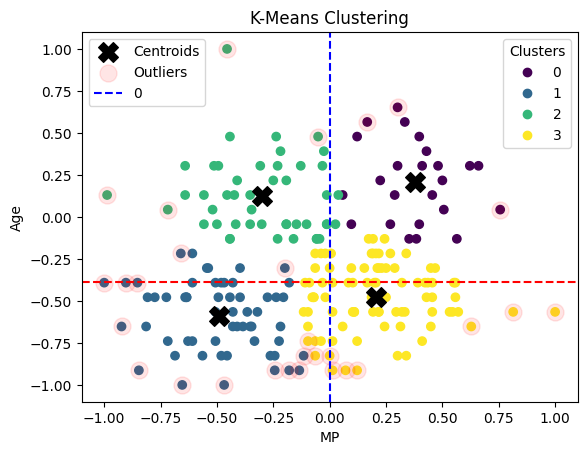

In [183]:
fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='X', s=200, label="Centroids")

X_outlier = df_check.iloc[np.where(distances_to_centroids > threshold)[0]][[a, b]].values

scatter3 = plt.scatter(X_outlier[:, 0], X_outlier[:, 1], c='red', marker='o', s=150, alpha=0.1, label="Outliers")

plt.axvline(x=0, color='blue', linestyle='--', label="0")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

In [178]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outlier_scores = -lof.fit_predict(X)

22


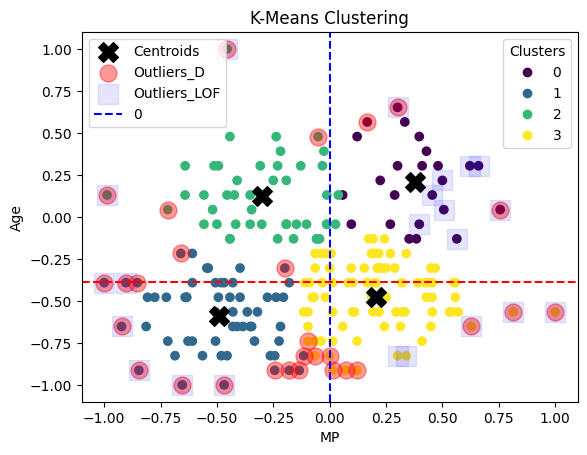

In [189]:
fig, ax = plt.subplots()

scatter1 = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
legend1 = ax.legend(*scatter1.legend_elements(), title="Clusters", loc='upper right')
ax.add_artist(legend1)
scatter2 = plt.scatter(centroids[:, 0], centroids[:, 1], c='k', marker='X', s=200, label="Centroids")

X_outlier_D = df_check.iloc[np.where(distances_to_centroids > threshold)[0]][[a, b]].values
X_outlier_LOF = df_check.iloc[np.where(outlier_scores == 1)[0]][[a, b]].values

scatter3 = plt.scatter(X_outlier_D[:, 0], X_outlier_D[:, 1], c='red', marker='o', s=150, alpha=0.4, label="Outliers_D")
scatter4 = plt.scatter(X_outlier_LOF[:, 0], X_outlier_LOF[:, 1], c='blue', marker='s', s=200, alpha=0.1, label="Outliers_LOF")

plt.axvline(x=0, color='blue', linestyle='--', label="0")
plt.axhline(y=x_mean_norm, color='red', linestyle='--', label="")

ax.legend(loc="upper left")

plt.xlabel(a)
plt.ylabel(b)
plt.title('K-Means Clustering')
plt.show()

In [213]:
df_check.iloc[np.where(distances_to_centroids > threshold)[0]]

,Player,Tm,labels,MP,Age
2,Nickeil Alexander-Walker,MIN,3,1.000000e+00,-0.565217
9,Patrick Baldwin Jr.,GSW,1,-1.346154e-01,-0.913043
15,Malik Beasley,LAL,1,-9.038462e-01,-0.391304
22,Christian Braun,DEN,3,-6.410256e-02,-0.826087
37,Max Christie,LAL,1,-4.679487e-01,-1.000000
70,Jeff Green,DEN,2,-5.128205e-02,0.478261
72,Quentin Grimes,NYK,3,-9.615385e-02,-0.739130
80,Udonis Haslem,MIA,2,-4.551282e-01,1.000000
82,Tyler Herro,MIA,1,-9.230769e-01,-0.652174
92,Jaren Jackson Jr.,MEM,3,6.282051e-01,-0.652174


In [216]:
df_check.iloc[np.where(outlier_scores == 1)[0]]

,Player,Tm,labels,MP,Age
2,Nickeil Alexander-Walker,MIN,3,1.000000,-0.565217
15,Malik Beasley,LAL,1,-0.903846,-0.391304
31,Jimmy Butler,MIA,0,0.500000,0.217391
37,Max Christie,LAL,1,-0.467949,-1.000000
56,Kevin Durant,PHO,0,0.660256,0.304348
57,Anthony Edwards,MIN,3,0.339744,-0.826087
64,Rudy Gobert,MIN,0,0.397436,-0.043478
80,Udonis Haslem,MIA,2,-0.455128,1.000000
82,Tyler Herro,MIA,1,-0.923077,-0.652174
85,Jrue Holiday,MIL,0,0.455128,0.130435


In [208]:
df_PO_.iloc[list(set(np.where(outlier_scores == 1)[0]) & set(np.where(distances_to_centroids > threshold)[0]))]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
192,196,Xavier Tillman Sr.,C,24,MEM,6,6,30.5,4.0,7.5,...,0.600,2.8,5.2,8.0,3.2,0.7,0.7,0.7,2.8,8.7
2,3,Nickeil Alexander-Walker,SG,24,MIN,5,4,29.6,3.0,7.0,...,0.667,0.2,1.8,2.0,1.4,0.6,0.2,0.8,1.8,8.4
130,133,Khris Middleton,SF,31,MIL,5,5,34.6,8.0,17.2,...,0.867,1.4,5.0,6.4,6.2,0.6,0.0,3.4,3.0,23.8
132,135,Shake Milton,SG,26,PHI,6,0,3.5,0.5,0.8,...,1.000,0.0,0.5,0.5,0.3,0.3,0.0,0.2,0.5,1.3
37,38,Max Christie,SG,19,LAL,9,0,3.7,0.6,1.1,...,0.500,0.1,0.7,0.8,0.3,0.0,0.1,0.0,0.0,1.4
100,103,Nikola Jovi?,PF,19,MIA,7,0,1.9,0.1,0.6,...,0.000,0.1,0.6,0.7,0.0,0.0,0.0,0.0,0.0,0.3
106,109,Jonathan Kuminga,PF,20,GSW,10,0,6.1,1.3,2.4,...,0.556,0.4,0.5,0.9,0.5,0.2,0.0,0.4,0.5,3.4
15,16,Malik Beasley,SG,26,LAL,11,0,8.3,0.9,3.1,...,1.000,0.3,0.5,0.7,0.2,0.1,0.0,0.2,0.5,3.0
80,82,Udonis Haslem,C,42,MIA,2,0,1.5,0.0,1.5,...,0.000,0.0,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0
82,84,Tyler Herro,SG,23,MIA,1,1,19.0,5.0,9.0,...,0.000,0.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,12.0


In [212]:
df_PO_.iloc[list(set(np.where(outlier_scores == 1)[0]) ^ set(np.where(distances_to_centroids > threshold)[0]))]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
64,65,Rudy Gobert,C,30,MIN,5,5,35.4,5.8,9.2,...,0.630,3.6,8.6,12.2,2.0,0.4,1.0,1.6,4.8,15.0
133,136,Josh Minott,SF,20,MIN,1,0,6.0,0.0,1.0,...,0.000,0.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,0.0
195,199,P.J. Tucker,PF,37,PHI,11,11,26.7,1.7,4.6,...,0.667,1.6,2.9,4.5,1.5,1.2,0.3,0.5,2.5,4.9
70,71,Jeff Green,PF,36,DEN,20,0,17.2,1.4,3.1,...,0.895,0.3,1.3,1.6,0.7,0.3,0.4,0.5,2.2,4.1
198,202,Dean Wade,PF,26,CLE,2,0,5.5,0.0,0.5,...,1.000,0.0,1.5,1.5,0.0,0.0,0.0,0.0,0.0,1.0
9,10,Patrick Baldwin Jr.,SF,20,GSW,3,0,3.7,0.0,1.0,...,0.000,0.0,1.0,1.0,0.3,0.0,0.0,0.0,0.0,0.0
138,141,Moses Moody,SG,20,GSW,12,0,13.4,1.9,3.6,...,0.917,0.6,2.0,2.6,0.7,0.4,0.3,0.2,1.5,5.8
139,142,Wendell Moore Jr.,SG,21,MIN,1,0,2.0,0.0,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
72,73,Quentin Grimes,SG,22,NYK,9,6,26.9,1.6,5.1,...,0.818,0.3,2.4,2.8,1.4,1.0,0.6,1.1,1.9,5.1
199,203,Ish Wainright,SF,28,PHO,6,0,3.5,0.2,0.7,...,0.000,0.0,0.2,0.2,0.0,0.0,0.2,0.0,0.3,0.5
